# Import

In [1]:
#   import packages
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import networkx as nx
import pickle
import functools

from ema_workbench import (
    Model,
    Policy,
    Scenario,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    util,
    ScalarOutcome,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress
from ema_workbench.em_framework import parameters_from_csv
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import prim
from ema_workbench import Samplers

Then, the model is loaded, and logging is set.

In [2]:
dike_model, planning_steps = get_model_for_problem_formulation(5)
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

First, the results of the policy discovery is loaded.

In [3]:
pareto_policies = pd.read_pickle(r'../generated_datasets/initial_Pareto_policies.pkl')

Then, the policies from the analysis are loaded into the model.

In [4]:
policies = []
for row_number in range(pareto_policies.shape[0]):
    policies.append(
        Policy(name=row_number, **pareto_policies.iloc[row_number, :-5].to_dict())
    )

General settings of the model are set.

In [5]:
n_scenarios = int(10_000)

# Model run

Then, run the model with the robust policies as input, and generate results over a lot of scenarios

In [ ]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenarios,
                                            policies=policies,
                                            uncertainty_sampling=Samplers.LHS
                                            )

with open(r'../generated_datasets/policy_uncertainty_test.pkl', 'wb') as file_pi:
    pickle.dump(results, file_pi)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 10000 scenarios * 45 policies * 1 model(s) = 450000 experiments
  0%|                                  | 163/450000 [00:16<10:34:08, 11.82it/s]

The results are then loaded in for analysis

In [6]:
scenario_results = pd.read_pickle(r'../generated_datasets/policy_uncertainty_test.pkl')
experiments, outcomes = scenario_results
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,123,114.999161,1.5,0.097214,267.026880,10.0,0.534503,41.222939,1.5,0.074974,...,0,3,0,0,0,0,0,0,0,dikesnet
1,12,114.507209,10.0,0.539099,117.390183,1.5,0.810281,209.314732,1.0,0.011289,...,0,3,0,0,0,0,0,1,0,dikesnet
2,93,67.728956,1.0,0.518512,105.078120,10.0,0.700256,89.773865,10.0,0.407997,...,0,3,0,0,0,0,0,2,0,dikesnet
3,76,189.885408,10.0,0.381116,147.348388,1.0,0.320509,329.767171,1.0,0.035767,...,0,3,0,0,0,0,0,3,0,dikesnet
4,105,220.684581,10.0,0.822199,341.672453,10.0,0.331055,210.102760,10.0,0.801983,...,0,3,0,0,0,0,0,4,0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224995,31,289.668313,1.0,0.052410,99.791409,1.5,0.475975,117.906512,1.5,0.997902,...,0,2,0,0,0,0,0,4995,44,dikesnet
224996,69,314.054116,1.0,0.103507,181.102471,1.5,0.875119,69.791147,1.0,0.342026,...,0,2,0,0,0,0,0,4996,44,dikesnet
224997,12,199.471980,1.0,0.020007,118.888179,1.0,0.490355,325.124367,10.0,0.750680,...,0,2,0,0,0,0,0,4997,44,dikesnet
224998,65,319.848416,1.5,0.459135,97.898038,1.5,0.945095,327.164295,1.5,0.325334,...,0,2,0,0,0,0,0,4998,44,dikesnet


Make a dataframe column for every timestep of the results.

In [7]:
policies_all_scenarios = pd.DataFrame()
for key, value in outcomes.items():
    temp_df = pd.DataFrame(value, columns=[key + ' '+ str(x) for x in range(len(value[0]))])
    policies_all_scenarios = pd.concat([policies_all_scenarios, temp_df], axis=1)

Add experiments input to the outputs for analysis

In [8]:
experiments_and_results = pd.concat([experiments,policies_all_scenarios], axis=1)

with open(r'../generated_datasets/policy_uncertainty_experiments_results.pkl', 'wb') as file_pi:
    pickle.dump(experiments_and_results, file_pi)

Combine the variables of different dikes and times

In [9]:
def combine_columns(dataframe, name):
    combined_columns = []
    for x in dataframe.columns:
        if name in x:
            combined_columns.append(x)

    dataframe['Total ' + str(name)] = dataframe[combined_columns].sum(axis=1)

In [10]:
combine_columns(policies_all_scenarios, 'Expected Annual Damage')
combine_columns(policies_all_scenarios, 'Dike Investment Costs')
combine_columns(policies_all_scenarios, 'Expected Number of Deaths')
combine_columns(policies_all_scenarios, 'RfR Total Costs')
combine_columns(policies_all_scenarios, 'Expected Evacuation Costs')

Generate statistics

In [11]:
aggregated_outcomes = pd.concat([experiments[['scenario','policy']],policies_all_scenarios.iloc[:,-5:]], axis=1)

stats_df = pd.DataFrame()
for column in aggregated_outcomes.iloc[:,2:].columns:
    stats_df[column + ' mean'] = aggregated_outcomes.groupby('policy').agg({column:['mean']})
    stats_df[column + ' std'] = aggregated_outcomes.groupby('policy').agg({column:['std']})

with open(r'../generated_datasets/policy_uncertainty_aggregated.pkl', 'wb') as file_pi:
    pickle.dump(aggregated_outcomes, file_pi)

Load results from Uncertainty Analysis

In [12]:
uncertainty_results = pd.read_pickle(r'../generated_datasets/policy_uncertainty_provinces.pkl')
experiments_and_results = pd.read_pickle(r'../generated_datasets/policy_uncertainty_experiments_results.pkl')
aggregated_outcomes = pd.read_pickle(r'../generated_datasets/policy_uncertainty_aggregated.pkl')
uncertainty_results_run = pd.read_pickle(r'../generated_datasets/policy_uncertainty_test.pkl')

# Calculate Robustness Metrics

First, the time data is combined into a single value, and saved into a DataFrame.

In [13]:
experiments, outcomes = uncertainty_results_run

results_df = pd.DataFrame()
for k in outcomes:
    test_list = []
    for i in range(len(experiments)):
        t = outcomes[k][i].sum()
        test_list.append(t)
    results_df[k]=test_list

Then, we calculate the cost of death for all death columns, making it able to easily construct a total cost.

In [14]:
death_cost_per_person = 6_300_000

# calculate the cost of death so every column has the same unit (€)
results_df["A.1_Deaths_Cost"]=results_df["A.1_Expected Number of Deaths"]*death_cost_per_person
results_df["A.2_Deaths_Cost"]=results_df["A.2_Expected Number of Deaths"]*death_cost_per_person
results_df["A.3_Deaths_Cost"]=results_df["A.3_Expected Number of Deaths"]*death_cost_per_person
results_df["A.4_Deaths_Cost"]=results_df["A.4_Expected Number of Deaths"]*death_cost_per_person
results_df["A.5_Deaths_Cost"]=results_df["A.5_Expected Number of Deaths"]*death_cost_per_person

to_drop = ["A.1_Expected Number of Deaths","A.2_Expected Number of Deaths","A.3_Expected Number of Deaths","A.4_Expected Number of Deaths","A.5_Expected Number of Deaths"]
results_df.drop(to_drop, axis=1, inplace=True)

### Gelderland - Overijssel Split

A function is created to sort the data into two columns: Gelderland and Overijssel.

In [15]:
def combine_columns_province(dataframe, name):
    combined_columns_gelderland = []
    combined_columns_overijssel = []
    for x in dataframe.columns:
        if name in x:
            if x.startswith('A.1') or x.startswith('A.2') or x.startswith('A.3'):
                combined_columns_gelderland.append(x)
            if x.startswith('A.4') or x.startswith('A.5'):
                combined_columns_overijssel.append(x)


    dataframe['Total ' + str(name) + ' Gelderland'] = dataframe[combined_columns_gelderland].sum(axis=1)
    dataframe['Total ' + str(name) + ' Overijssel'] = dataframe[combined_columns_overijssel].sum(axis=1)


A new DataFrame is then created with the province-sorted data.

In [16]:
provinces = results_df.copy()

combine_columns_province(provinces, 'Expected Annual Damage')
combine_columns_province(provinces, 'Dike Investment Costs')
combine_columns_province(provinces, 'Deaths_Cost')

The excess columns are then deleted, and columns are created with total cost and total cost for the province of Overijssel.

In [17]:
aggregated_outcomes_provinces = pd.concat([experiments[['scenario','policy']],provinces], axis=1).iloc[:,2:]

for x in aggregated_outcomes_provinces.columns:

        if x.startswith('A.1') or x.startswith('A.2') or x.startswith('A.3') or x.startswith('A.4') or x.startswith('A.5'):
            aggregated_outcomes_provinces.drop(x, axis=1, inplace=True)
        else:
            pass

aggregated_outcomes_provinces['total_cost[€]']= aggregated_outcomes_provinces.sum(axis=1)
overijssel_sum = ['RfR Total Costs','Expected Evacuation Costs','Total Expected Annual Damage Overijssel','Total Dike Investment Costs Overijssel','Total Deaths_Cost Overijssel']
aggregated_outcomes_provinces['total_cost[€]_overijssel']= aggregated_outcomes_provinces.loc[:,overijssel_sum].sum(axis=1)

Lastly, we add the policy number.

In [33]:
aggregated_outcomes_provinces_policy = aggregated_outcomes_provinces.copy()
aggregated_outcomes_provinces_policy['policy'] = experiments.iloc[:,-2]

with open(r'..\generated_datasets\policy_all_scenarios.pkl','wb') as pickle_file:
    pickle.dump(aggregated_outcomes_provinces_policy, pickle_file)

# Generate outcome optimal for Overijssel

The best 5 (cheapest) policies are selected. For this, we need the robustness metric again: Mean Square Deviation. For this, we construct a function that makes the column.

In [19]:
def mean_square_deviation(df_input, df_output, column_name):
    grouping = df_input.groupby(['policy']).agg({column_name:['mean', 'std']})
    df_output['MSD ' + column_name] = np.square(grouping[(column_name, 'mean')]) + np.square(grouping[(column_name, 'std')])
    grouping.drop([(column_name, 'mean'), (column_name, 'std')], axis=1, inplace=True)

    #return grouping

The robustness metric of the policies is calculated and stored in a DataFrame for comparison.

In [29]:
robust_df = pd.DataFrame()

mean_square_deviation(aggregated_outcomes_provinces_policy, robust_df, 'RfR Total Costs')
mean_square_deviation(aggregated_outcomes_provinces_policy, robust_df, 'Expected Evacuation Costs')
mean_square_deviation(aggregated_outcomes_provinces_policy, robust_df, 'Total Expected Annual Damage Overijssel')
mean_square_deviation(aggregated_outcomes_provinces_policy, robust_df, 'Total Dike Investment Costs Overijssel')
mean_square_deviation(aggregated_outcomes_provinces_policy, robust_df, 'Total Deaths_Cost Overijssel')

The top 5 policies are determined and stored.

In [30]:
grouping = aggregated_outcomes_provinces_policy.groupby(['policy']).agg({'total_cost[€]_overijssel':['mean', 'std']})
grouping[('total_cost[€]_overijssel','mean square deviation')] = np.square(grouping[('total_cost[€]_overijssel', 'mean')]) + np.square(grouping[('total_cost[€]_overijssel', 'std')])

In [31]:
n_scenarios_of_interest = 5

results_of_interest = grouping.sort_values(by=('total_cost[€]_overijssel','mean square deviation'), ascending=True).head(n_scenarios_of_interest)

with open(r'..\generated_datasets\final_policies_overijssel.pkl','wb') as pickle_file:
    pickle.dump(results_of_interest, pickle_file)

results_of_interest

total_cost[€]_overijssel                                    
                           mean           std mean square deviation
policy                                                             
26                 8.331391e+07  1.933501e+08          4.432547e+16
11                 8.407651e+07  1.934453e+08          4.448995e+16
5                  1.760816e+08  1.291865e+08          4.769388e+16
44                 1.763057e+08  1.298316e+08          4.793996e+16
9                  1.764013e+08  1.300868e+08          4.803999e+16

### Visualization

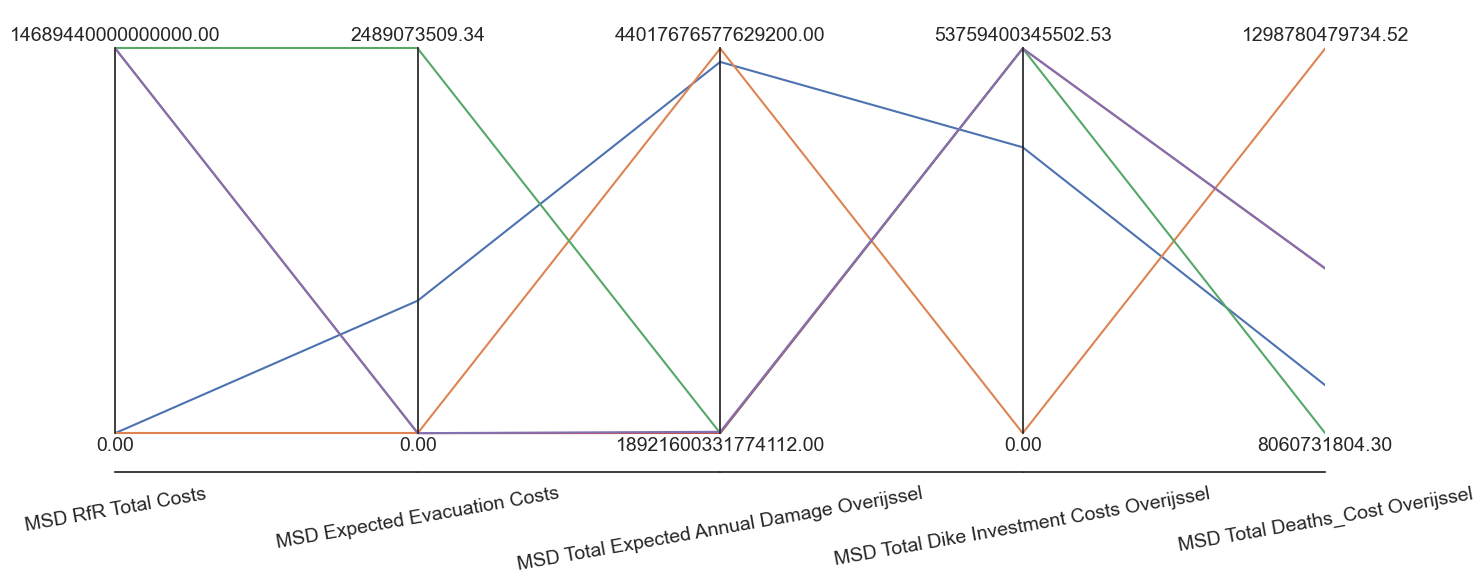

In [32]:
data = robust_df.iloc[results_of_interest.index.values]
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits, rot=10)
paraxes.plot(data)
sns.despine()
plt.savefig(r'../visualizations/Scenario_Discovery/pareto_visualization_overijssel.png', bbox_inches='tight')
sns.set(rc={'figure.figsize': (15, 6)})

# Generate outcome optimal for Gelderland and Overijssel combined.

The same is done for the total cost of the provinces of Gelderland and Overijssel combined.

In [24]:
robust_df = pd.DataFrame()

aggregated_outcomes['Total Deaths_Cost'] = aggregated_outcomes['Total Expected Number of Deaths']*death_cost_per_person

mean_square_deviation(aggregated_outcomes, robust_df, 'Total Expected Annual Damage')
mean_square_deviation(aggregated_outcomes, robust_df, 'Total Dike Investment Costs')
mean_square_deviation(aggregated_outcomes, robust_df, 'Total Deaths_Cost')
mean_square_deviation(aggregated_outcomes, robust_df, 'Total RfR Total Costs')
mean_square_deviation(aggregated_outcomes, robust_df, 'Total Expected Evacuation Costs')

The top 5 is determined and stored.

In [25]:
grouping = aggregated_outcomes_provinces_policy.groupby(['policy']).agg({'total_cost[€]':['mean', 'std']})
grouping[('total_cost[€]','mean square deviation')] = np.square(grouping[('total_cost[€]', 'mean')]) + np.square(grouping[('total_cost[€]', 'std')])

In [26]:
n_scenarios_of_interest = 5

results_of_interest = grouping.sort_values(by=('total_cost[€]','mean square deviation'), ascending=True).head(n_scenarios_of_interest)

with open(r'..\generated_datasets\final_policies.pkl','wb') as pickle_file:
    pickle.dump(results_of_interest, pickle_file)

results_of_interest

total_cost[€]                                    
                mean           std mean square deviation
policy                                                  
36      1.033884e+09  7.140469e+08          1.578779e+18
2       1.181345e+09  7.133925e+08          1.904505e+18
10      1.373723e+09  9.660506e+08          2.820368e+18
25      1.422984e+09  9.787605e+08          2.982856e+18
1       1.481486e+09  8.880334e+08          2.983405e+18

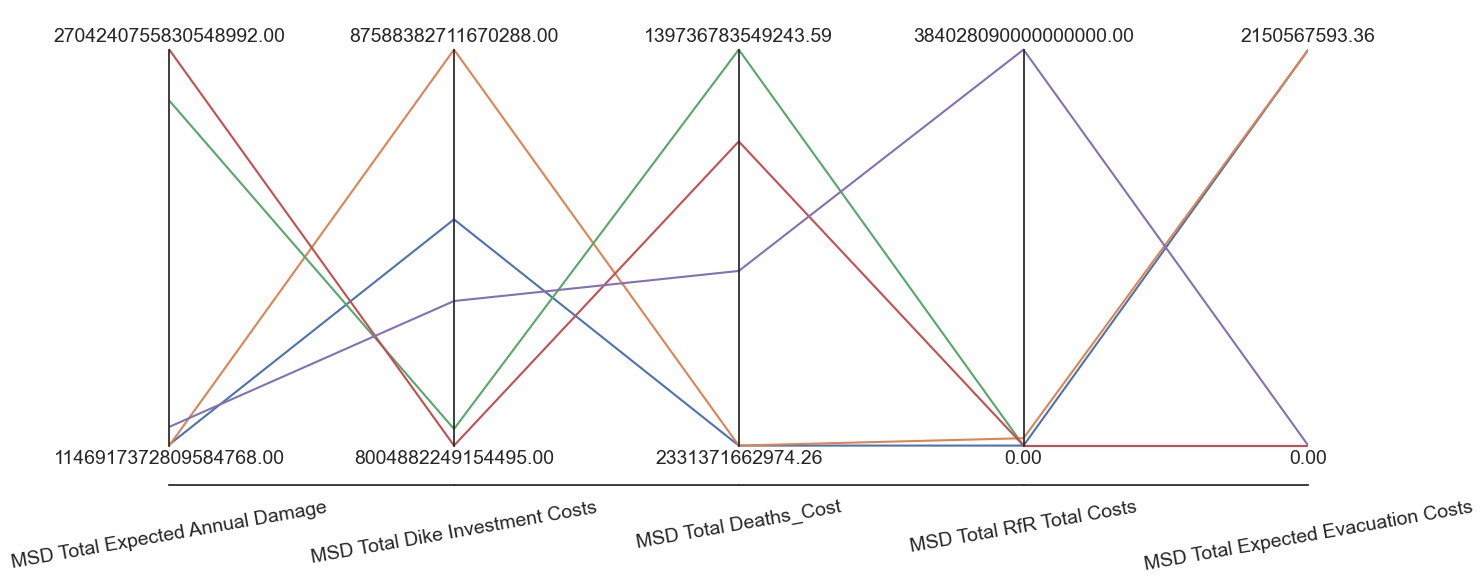

In [27]:
data = robust_df.iloc[results_of_interest.index.values]
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits, rot=10)
paraxes.plot(data)
sns.despine()
plt.savefig(r'../visualizations/Scenario_Discovery/pareto_visualization.png', bbox_inches='tight')
sns.set(rc={'figure.figsize': (15, 6)})